<a href="https://colab.research.google.com/github/SparkWorks13/Galaxy-Star-Classification-Model/blob/main/galaxyStarID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import pandas
import torchvision.transforms as transforms
from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import os

!pip install pyyaml h5py
!pip install kaggle
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d divyansh22/dummy-astronomy-data
!unzip dummy-astronomy-data.zip -d /content/drive/MyDrive/galaxyImages

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
 59% 5.00M/8.46M [00:00<00:00, 23.1MB/s]
100% 8.46M/8.46M [00:00<00:00, 37.0MB/s]
Archive:  dummy-astronomy-data.zip
replace /content/drive/MyDrive/galaxyImages/Cutout Files/galaxy/IC3521-H01_1260_751_3.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
trainSet = tf.keras.preprocessing.image_dataset_from_directory(
  r'/content/drive/MyDrive/galaxyImages/Cutout Files',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(180, 180), batch_size=64)

valSet = tf.keras.preprocessing.image_dataset_from_directory(
  r'/content/drive/MyDrive/galaxyImages/Cutout Files',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(180, 180), batch_size=64)

trainSet = trainSet.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
valSet = valSet.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Found 3986 files belonging to 2 classes.
Using 3189 files for training.
Found 3986 files belonging to 2 classes.
Using 797 files for validation.


In [ ]:
dataAugmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(180,
                                  180,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [ ]:
model = Sequential([
  dataAugmentation,
  layers.Rescaling(1./255, input_shape=(180, 180, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(2)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

Epoch 1/15
50/50 [==============================] - 204s 4s/step - loss: 0.5651 - accuracy: 0.7645 - val_loss: 0.5476 - val_accuracy: 0.7604
Epoch 2/15
50/50 [==============================] - 125s 3s/step - loss: 0.5429 - accuracy: 0.7645 - val_loss: 0.5342 - val_accuracy: 0.7604
Epoch 3/15
50/50 [==============================] - 119s 2s/step - loss: 0.5302 - accuracy: 0.7645 - val_loss: 0.5168 - val_accuracy: 0.7604
Epoch 4/15
50/50 [==============================] - 125s 2s/step - loss: 0.5017 - accuracy: 0.7632 - val_loss: 0.4523 - val_accuracy: 0.7666
Epoch 5/15
50/50 [==============================] - 119s 2s/step - loss: 0.4601 - accuracy: 0.7749 - val_loss: 0.4551 - val_accuracy: 0.7604
Epoch 6/15
50/50 [==============================] - 124s 2s/step - loss: 0.4297 - accuracy: 0.7937 - val_loss: 0.3780 - val_accuracy: 0.8269
Epoch 7/15
50/50 [==============================] - 119s 2s/step - loss: 0.3949 - accuracy: 0.8087 - val_loss: 0.3600 - val_accuracy: 0.8419
Epoch 8/15
50

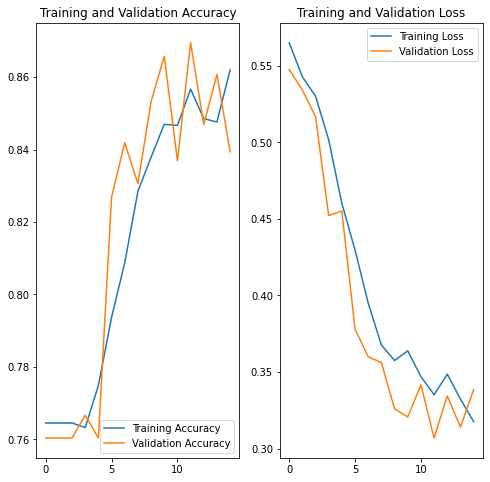

In [ ]:
history = model.fit(
  trainSet,
  validation_data=valSet,
  epochs=15
)
accuracy = history.history['accuracy']
valAccuracy = history.history['val_accuracy']

loss = history.history['loss']
valLoss = history.history['val_loss']

epochsRange = range(15)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochsRange, accuracy, label='Training Accuracy')
plt.plot(epochsRange, valAccuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochsRange, loss, label='Training Loss')
plt.plot(epochsRange, valLoss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model.save("/content/drive/MyDrive/galaxyModel")

In [ ]:
galaxyModel = tf.keras.models.load_model("/content/drive/MyDrive/galaxyModel")

In [ ]:
classNames = ['galaxy', 'star']
img = tf.keras.utils.load_img(
    "/content/drive/MyDrive/testImages/galaxy1.jpg", target_size=(180, 180))
imgArray = tf.keras.utils.img_to_array(img)
imgArray = tf.expand_dims(imgArray, 0)

predictions = galaxyModel.predict(imgArray)
score = tf.nn.softmax(predictions[0])

print(
    "This image is most likely a {} with a {:.2f} percent confidence."
    .format(classNames[np.argmax(score)], 100 * np.max(score)))

1/1 [==============================] - 0s 54ms/step
This image is most likely a galaxy with a 66.84 percent confidence.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
